# Pytorch Practice


> ### Multi Layer Perceptron using Pytorch on MNIST dataset

## 0. MLP 모델의 설계 순서
1. module import
2. 모델 설계 시 활용하는 장비 확인
3. data set download (split tran/test set)
4. data 확인
5. MLP 모델 설계
6. Optimizer, Objective Func 설정
7. train data에 대한 모델 성능 확인하는 함수 정의 (ex. accuracy, loss)
8. test data에 대한 모델의 성능 확인하는 함수 정의 (ex. accuracy, loss)
9. MLP 학습 실행하며 tran, test set의 loss와 test set accuracy 확인

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import warnings

warnings.filterwarnings(action='ignore')

## 2. 모델 설계 시 활용하는 장비 확인 (GPU?CPU?)

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.8.1  Device: cuda


### 하이퍼파라미터 설정

In [3]:
BATCH_SIZE = 32 # 한 번 학습할 때 32개의 데이터를 학습한다.
EPOCHS = 10 # 존재하고 있는 미니배치를 전부 이용하는 횟수. 즉, 학습을 몇 번 반복할 것인지.

## 3. MNIST Dataset Download
MNIST는 사람이 손으로 쓴 숫자로 이루어지는 대형 데이터베이스다.  
각 이미지는 28*28 pexels로 구성되며 흰색과 검정색으로 이루어진 gray scale image [0 to 255]다.

In [4]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

- mnist 데이터는 이미지 데이터이다. 데이터를 다운로드할 때 transform을 사용해 기본적인 전처리를 진행한다. ToTensor()는 데이터를 tensor형태로 변경시킨다. 또한 각각의 픽셀은  [0 to 255] 사이의 스칼라 값으로 구성되어 있는데 이를 [0 to 1] 사이의 값으로 정규화 한다.  
- shuffle은 데이터의 순서를 섞고자 할 때 사용한다. 모델이 학습을 진행할 때 label 정보의 순서를 암기해 학습을 진행할 우려가 있으므로 데이터 순서를 섞어 학습한다.

## 4. 데이터 확인하기
미니배치 단위로 할당한 데이터의 개수와 형태를 확인한다.

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


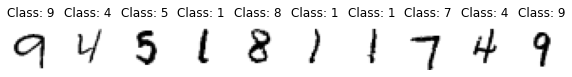

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

## 5. MLP 모델 설계
28 * 28 픽셀의 이미지 데이터가 Flatten되어 모델의 input으로 들어간다.
* 첫 번째 레이어는 mnist 이미지 한 장을 입력으로 받고 512개의 node를 만든다.
* 두 번째 레이어는 512개의 input을 받고 256개의 node를 만든다.
* 세 번째 레이어는 256개의 input을 받고 10개의 node를 만든다. (최종적으로 분류해야 할 output의 개수가 0~9까지 총 10개이므로 최종 output node 수는 10.)

In [7]:
class MLP(nn.Module):
    
    def __init__(self):
        
        super(MLP, self).__init__() 
        
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    # 설계한 모델의 forward propagation. 모델에 데이터를 입력했을 때 output을 계산하기까지의 과정
    def forward(self, x):
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        
        return x

view 메서드는 input tensor와 데이터는 같지만 shape가 다른 tensor를 반환한다. 이 메서드를 통해 flatten된 데이터는 첫 번째 레이어에 input으로 들어간다. 그 후 반환된 값은 sigmoid 함수를 통과해 두 번째 레이어의 input이 된다. 마찬가지로 그 후 반환된 값은 다시 sigmoid 함수를 통과해 세 번째 레이어의 input이 되고, 세 번째 레이어에서 반환된 값(prediction)은 log_softmax 함수를 통과해 최종 output을 계산하게 된다.(log_softmax를 사용하는 이유는 softmax보다 loss값에 대한 gradient 값을 더 원활하게 계산하기 때문.)

## 6. Optimizer, Objective Function 설정

In [8]:
model = MLP().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### TIP

torchsummary 패키지를 이용하면 pytorch에서도 keras처럼 모델을 깔끔하게 출력해볼 수 있다!

In [ ]:
# !pip install torchsummary

In [10]:
from torchsummary import summary

model = MLP().to(DEVICE)
summary(model, input_size=(1,28,28)) # input_size = (channels, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.04
Estimated Total Size (MB): 2.05
----------------------------------------------------------------


## 7. Train data에 대한 모델 성능 확인하는 함수 정의
기존에 정의한 이미지 데이터와 레이블 데이터를 이용해 MLP 모델을 학습하는 함수를 정의한다.

- train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 mini-batch 단위로 묶여 저장되어 있다. 해당 train_loader 내의 미니배치 단위로 저장된 데이터를 순서대로 MLP 모델을 학습시킨다.  
- 미니배치 내에 있는 데이터를 이용해 모델을 학습시키기 위해서는 모든 데이터를 DEVICE에 할당해야 한다.  
- DEVICE에 데이터를 할당할 경우, 과거에 이용한 미니 배치 내에 있는 데이터를 바탕으로 계산된 loss의 gradient 값이 optimizer에 할당되어 있으므로 optimizer의 gradient를 초기화한다.  
- DEVICE에 할당한 이미지를 모델의 input으로, output을 계산한다. 계산된 output과 DEVICE의 레이블 데이터를 CrossEntropy를 이용해 loss를 계산한다.  
- loss 값을 계산한 결과를 바탕으로 backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당하고, 할당된 gradient 값을 이용해 파라미터 값을 업데이트 한다.

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    print("============================ Train ===========================")
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Training Epoch: {}  iteration : {:5d}  Train Loss: {:.6f}".format(epoch, batch_idx * len(image), loss.item()))
        #if batch_idx % log_interval == 0:
        #    print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
        #        epoch, batch_idx * len(image), 
        #        len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
        #        loss.item()))
    print("==============================================================")

## 8. Test data에 대한 모델의 성능 확인하는 함수 정의
학습의 진행 과정을 모니터링하기 위한 함수이다.

- test data를 통해 모델을 평가할 때는 gradient를 통해 파라미터 값이 업데이트 되면 안된다.

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 9. MLP 학습 실행

In [11]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("---------------------------- Test ----------------------------")
    print("Test Epoch: {} Test Loss: {:.4f}  Test Accuracy: {:.4f}".format(epoch, test_loss, test_accuracy))
    print("--------------------------------------------------------------")

============================ Train ===========================
Training Epoch: 1  iteration :     0  Train Loss: 2.329282
Training Epoch: 1  iteration :  6400  Train Loss: 2.310580
Training Epoch: 1  iteration : 12800  Train Loss: 2.351052
Training Epoch: 1  iteration : 19200  Train Loss: 2.299035
Training Epoch: 1  iteration : 25600  Train Loss: 2.273660
Training Epoch: 1  iteration : 32000  Train Loss: 2.318981
Training Epoch: 1  iteration : 38400  Train Loss: 2.242330
Training Epoch: 1  iteration : 44800  Train Loss: 2.256781
Training Epoch: 1  iteration : 51200  Train Loss: 2.236683
Training Epoch: 1  iteration : 57600  Train Loss: 2.270930
---------------------------- Test ----------------------------
Test Epoch: 1 Test Loss: 2.2304  Test Accuracy: 0.1277
--------------------------------------------------------------
============================ Train ===========================
Training Epoch: 2  iteration :     0  Train Loss: 2.283923
Training Epoch: 2  iteration :  6400  Train 

Training Epoch: 10  iteration :  6400  Train Loss: 0.543210
Training Epoch: 10  iteration : 12800  Train Loss: 0.561122
Training Epoch: 10  iteration : 19200  Train Loss: 0.353615
Training Epoch: 10  iteration : 25600  Train Loss: 0.081553
Training Epoch: 10  iteration : 32000  Train Loss: 0.309431
Training Epoch: 10  iteration : 38400  Train Loss: 0.313476
Training Epoch: 10  iteration : 44800  Train Loss: 0.674694
Training Epoch: 10  iteration : 51200  Train Loss: 0.137903
Training Epoch: 10  iteration : 57600  Train Loss: 0.241868
---------------------------- Test ----------------------------
Test Epoch: 10 Test Loss: 0.3350  Test Accuracy: 0.9020
--------------------------------------------------------------
